In [1]:
import pandas as pd
import numpy as np
import json
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split
import anndata as ad
import scanpy as sc
import plotly.express as px
import sys
import os
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F

In [2]:
file_path = '/home/BS94_SUR/phD/review/datasets/array express /E-MTAB-3732'

In [3]:
import sys
import os
sys.path.append('/home/BS94_SUR/phD/review/utils')
import simple_VAE
import anndata_loading_preprocessing
import classification
import clustering
import dataset_transformation
import plot_functions
from anndata_loading_preprocessing import read_dscigm_datasets, convert_anndata_in_df, preprocessing_anndata, plot_umap_adata, write_adata, apply_clustering_anndata
from clustering import plot_losses, extract_latent_results, apply_reducuction_algo, plot_reduced_data, apply_clustering_algo, apply_clustering_metrics
from dataset_transformation import save_results_to_dataframe, apply_melt_function, save_hyperparmeters_optimization_results, save_best_optimization_results, save_mse_results
from plot_functions import create_umap_scatter, plot_df_melted
from classification import extract_x_y_from_adata, encode_y, transpose_label_mapping, filter_classes, apply_classifier, compute_classification_metrics, map_label_mapping, compute_roc_auc, compute_classification_adata, stratify_small_classes


In [4]:
sys.path.append('/home/BS94_SUR/phD/review/models reproductibility/PriorVAE/github code')
import simpleVAE
import utils
import Reconstruction_performance_metrics
from simpleVAE import Encoder, Decoder, simpleVAE
from utils import EarlyStopping, LRScheduler
from Reconstruction_performance_metrics import calculate_sample_wise_correlation_numpy, calculate_overall_reconstruction_each_model, calculate_overall_reconstruction_each_model_detailed_info, input_reconstruction_pairwise_correlation_plot, input_reconstruction_pairwise_correlation_with_annotation_labels

/opt/conda/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/opt/conda/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


# Load Array Files

In [5]:
meta_sdrf_df = pd.read_table(file_path + "/" + "E-MTAB-3732.sdrf.txt", sep='\t')
print(meta_sdrf_df.shape)
meta_sdrf_df.head(5)

(27887, 26)


Source Name Material Type Characteristics[organism]  \
0    Sample 1          cell              Homo sapiens   
1    Sample 2          cell              Homo sapiens   
2    Sample 3          cell              Homo sapiens   
3    Sample 4          cell              Homo sapiens   
4    Sample 5          cell              Homo sapiens   

  Characteristics[cell type] Characteristics[cell line]  \
0      lung cancer cell line                 RERF-LC-KJ   
1   ovarian cancer cell line                    FU-OV-1   
2   colonic cancer cell line                   COLO-205   
3   colonic cancer cell line                       LOVO   
4      lung cancer cell line                       H661   

  Characteristics[tissue supergroup] Characteristics[organism part]  \
0                               lung                           lung   
1                              ovary                          ovary   
2                         colorectal                          colon   
3                         colorectal                          colon   
4                               lung                           lung   

  Characteristics[metastatic tissue] Characteristics[disease]  \
0                     not applicable              lung cancer   
1                     not applicable          ovary carcinoma   
2                            ascites     colon adenocarcinoma   
3                     not applicable             colon cancer   
4                         lymph node   large cell lung cancer   

  Characteristics[clinical history]  ... Labeled Extract Name   Label  \
0                                    ...      Sample 1:biotin  biotin   
1                                    ...      Sample 2:biotin  biotin   
2                                    ...      Sample 3:biotin  biotin   
3                                    ...      Sample 4:biotin  biotin   
4                                    ...      Sample 5:biotin  biotin   

      Assay Name Technology Type Comment [ArrayExpress accession]  \
0  GSM274674.cel     array assay                     E-GEOD-10843   
1  GSM274702.cel     array assay                     E-GEOD-10843   
2  GSM274717.cel     array assay                     E-GEOD-10843   
3  GSM274729.cel     array assay                     E-GEOD-10843   
4  GSM274760.cel     array assay                     E-GEOD-10843   

               Derived Array Data File  \
0  processedMatrix.Aurora.july2015.txt   
1  processedMatrix.Aurora.july2015.txt   
2  processedMatrix.Aurora.july2015.txt   
3  processedMatrix.Aurora.july2015.txt   
4  processedMatrix.Aurora.july2015.txt   

             Comment [Derived ArrayExpress FTP file]   Factor Value[disease]  \
0  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...             lung cancer   
1  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...         ovary carcinoma   
2  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...    colon adenocarcinoma   
3  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...            colon cancer   
4  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...  large cell lung cancer   

    Factor Value[cell type] Factor Value[cell line]  
0     lung cancer cell line              RERF-LC-KJ  
1  ovarian cancer cell line                 FU-OV-1  
2  colonic cancer cell line                COLO-205  
3  colonic cancer cell line                    LOVO  
4     lung cancer cell line                    H661  

[5 rows x 26 columns]

In [8]:
meta_sdrf_df.columns

Index(['Source Name', 'Material Type', 'Characteristics[organism]',
       'Characteristics[cell type]', 'Characteristics[cell line]',
       'Characteristics[tissue supergroup]', 'Characteristics[organism part]',
       'Characteristics[metastatic tissue]', 'Characteristics[disease]',
       'Characteristics[clinical history]', 'Characteristics[compound]',
       'Characteristics[growth condition]', 'Characteristics[stimulus]',
       'Characteristics[genotype]', 'Characteristics[RNAi]',
       'Characteristics[phenotype]', 'Labeled Extract Name', 'Label',
       'Assay Name', 'Technology Type', 'Comment [ArrayExpress accession]',
       'Derived Array Data File', 'Comment [Derived ArrayExpress FTP file]',
       'Factor Value[disease]', 'Factor Value[cell type]',
       'Factor Value[cell line]'],
      dtype='object')

In [ ]:
meta_sdrf_df.iloc[:, -10:]

In [7]:
meta_idf_df = pd.read_table(file_path + "/" + "E-MTAB-3732.idf.txt", sep='\t')
print(meta_idf_df.shape)
meta_idf_df

(33, 2)


Comment[ArrayExpressAccession]  \
MAGE-TAB Version                          1.1                                                NaN                                                        NaN   
Investigation Title                       A comprehensive human expression map               NaN                                                        NaN   
Comment[Submitted Name]                   A comprehensive human expression map               NaN                                                        NaN   
Experiment Description                    A compiled human gene expression, ontology-anno... NaN                                                        NaN   
Experimental Design                       disease state design                               organism part comparison design    cell type comparison design   
Experimental Design Term Source REF       EFO                                                EFO                                                        EFO   
Experimental Design Term Accession Number EFO_0001756                                        EFO_0001750                                        EFO_0001745   
Experimental Factor Name                  disease                                            cell line                                            cell type   
Experimental Factor Type                  disease                                            cell line                                            cell type   
Person Last Name                          Torrente                                           NaN                                                        NaN   
Person First Name                         Aurora                                             NaN                                                        NaN   
Person Mid Initials                       NaN                                                NaN                                                        NaN   
Person Email                              aurora@ebi.ac.uk                                   NaN                                                        NaN   
Person Phone                              NaN                                                NaN                                                        NaN   
Person Fax                                NaN                                                NaN                                                        NaN   
Person Address                            NaN                                                NaN                                                        NaN   
Person Affiliation                        NaN                                                NaN                                                        NaN   
Person Roles                              submitter                                          NaN                                                        NaN   
Date of Experiment                        2015-05-23                                         NaN                                                        NaN   
Public Release Date                       2015-07-23                                         NaN                                                        NaN   
Protocol Name                             P-MTAB-45988                                       NaN                                                        NaN   
Protocol Type                             normalization data transformation protocol         NaN                                                        NaN   
Protocol Term Source REF                  EFO                                                NaN                                                        NaN   
Protocol Term Accession Number            EFO_0003816                                        NaN                                                        NaN   
Protocol Description                      Data normalization was carried out using fRMA i... NaN                                                      

In [5]:
processed_matrix = pd.read_table(file_path + "/" + "processedMatrix.Aurora.july2015.txt", sep='\t')

In [6]:
processed_matrix = processed_matrix.set_index(processed_matrix .iloc[:, 0], drop=True)
processed_matrix 

CompositeSequence Identifier   Sample 1  \
CompositeSequence Identifier                                           
1007_s_at                                       1007_s_at  11.112964   
1053_at                                           1053_at   8.633534   
117_at                                             117_at   5.706326   
121_at                                             121_at   8.432861   
1255_g_at                                       1255_g_at   3.612596   
...                                                   ...        ...   
AFFX-ThrX-5_at                             AFFX-ThrX-5_at   4.421888   
AFFX-ThrX-M_at                             AFFX-ThrX-M_at   4.381899   
AFFX-TrpnX-3_at                           AFFX-TrpnX-3_at   2.981174   
AFFX-TrpnX-5_at                           AFFX-TrpnX-5_at   3.463121   
AFFX-TrpnX-M_at                           AFFX-TrpnX-M_at   3.379799   

                               Sample 2   Sample 3   Sample 4   Sample 5  \
CompositeSequence Identifier                                               
1007_s_at                      9.001601   9.730824  10.085825   9.023190   
1053_at                        7.133591   8.750263   8.036026   8.250181   
117_at                         5.600561   5.535385   5.583420   5.636544   
121_at                        11.214049   8.758270   8.715002   8.505976   
1255_g_at                      3.507581   3.490875   3.509387   3.488148   
...                                 ...        ...        ...        ...   
AFFX-ThrX-5_at                 4.362201  10.320562  12.038390  11.873502   
AFFX-ThrX-M_at                 3.958162  10.860555  12.457624  12.418175   
AFFX-TrpnX-3_at                2.994373   2.912331   2.914637   2.931114   
AFFX-TrpnX-5_at                3.468782   3.413955   3.349388   3.357858   
AFFX-TrpnX-M_at                3.321463   3.373941   3.273376   3.352512   

                               Sample 6   Sample 7   Sample 8   Sample 9  ...  \
CompositeSequence Identifier                                              ...   
1007_s_at                     10.808370   8.539526   9.622165   9.460736  ...   
1053_at                        7.440340   7.338118   9.099065   8.762662  ...   
117_at                         5.576865   5.582104   5.855862   5.689304  ...   
121_at                         8.961191   8.626493   8.573742  10.131643  ...   
1255_g_at                      3.487915   3.782542   3.466322   3.493898  ...   
...                                 ...        ...        ...        ...  ...   
AFFX-ThrX-5_at                12.030320  11.989423  12.013706   4.507913  ...   
AFFX-ThrX-M_at                12.372327  12.507955  12.400053   3.922760  ...   
AFFX-TrpnX-3_at                3.025995   3.010189   2.990912   3.056227  ...   
AFFX-TrpnX-5_at                3.373527   3.530112   3.495274   3.549172  ...   
AFFX-TrpnX-M_at                3.286343   3.301741   3.464684   3.364227  ...   

                              Sample 27878  Sample 27879  Sample 27880  \
CompositeSequence Identifier                                             
1007_s_at                        10.086999      9.852103      9.506810   
1053_at                           6.663614      6.399413      7.091557   
117_at                            6.375936      6.729538      6.441134   
121_at                            7.592054      7.135566      7.095982   
1255_g_at                         3.368299      3.478556      3.403848   
...                                    ...           ...           ...   
AFFX-ThrX-5_at                    3.408162      3.584460      3.692155   
AFFX-ThrX-M_at                    3.216134      3.256286      3.379351   
AFFX-TrpnX-3_at                   2.942239      2.969003      3.020942   
AFFX-TrpnX-5_at                   3.485284      3.520998      3.460880   
AFFX-TrpnX-M_at                   3.217478      3.298865      3.075942   

                              Sample 27881  Sample 27882  Sample 27883  \
CompositeSeq

In [7]:
processed_matrix = processed_matrix.iloc[1:processed_matrix.shape[0], 1:processed_matrix.shape[1]]

In [8]:
#processed_matrix.to_pickle(file_path + '/' + 'all_samples_transcript_level.pkl')

In [9]:
with open(file_path + '/' + 'E-MTAB-3732.json') as json_file:
    data = json.load(json_file)

# Meta information

In [10]:
meta_sdrf_df.columns

Index(['Source Name', 'Material Type', 'Characteristics[organism]',
       'Characteristics[cell type]', 'Characteristics[cell line]',
       'Characteristics[tissue supergroup]', 'Characteristics[organism part]',
       'Characteristics[metastatic tissue]', 'Characteristics[disease]',
       'Characteristics[clinical history]', 'Characteristics[compound]',
       'Characteristics[growth condition]', 'Characteristics[stimulus]',
       'Characteristics[genotype]', 'Characteristics[RNAi]',
       'Characteristics[phenotype]', 'Labeled Extract Name', 'Label',
       'Assay Name', 'Technology Type', 'Comment [ArrayExpress accession]',
       'Derived Array Data File', 'Comment [Derived ArrayExpress FTP file]',
       'Factor Value[disease]', 'Factor Value[cell type]',
       'Factor Value[cell line]'],
      dtype='object')

In [20]:
value_counts = meta_sdrf_df['Characteristics[organism part]'].value_counts().reset_index()
value_counts.columns = ['Organism Part', 'Count']

In [21]:
value_counts

Organism Part  Count
0                                              5156
1                                bone marrow   3099
2                           peripheral blood   2454
3                                     breast   1722
4                                      blood   1241
..                                       ...    ...
243                              conjunctiva      1
244                                      gum      1
245                   heart atrial appendage      1
246                          coronary artery      1
247  metastatic renal cell carcinoma in lung      1

[248 rows x 2 columns]

In [13]:
# Samples with missing organisms
value_counts[value_counts['Organism Part'] == '  ']

Organism Part  Count
0                 5156

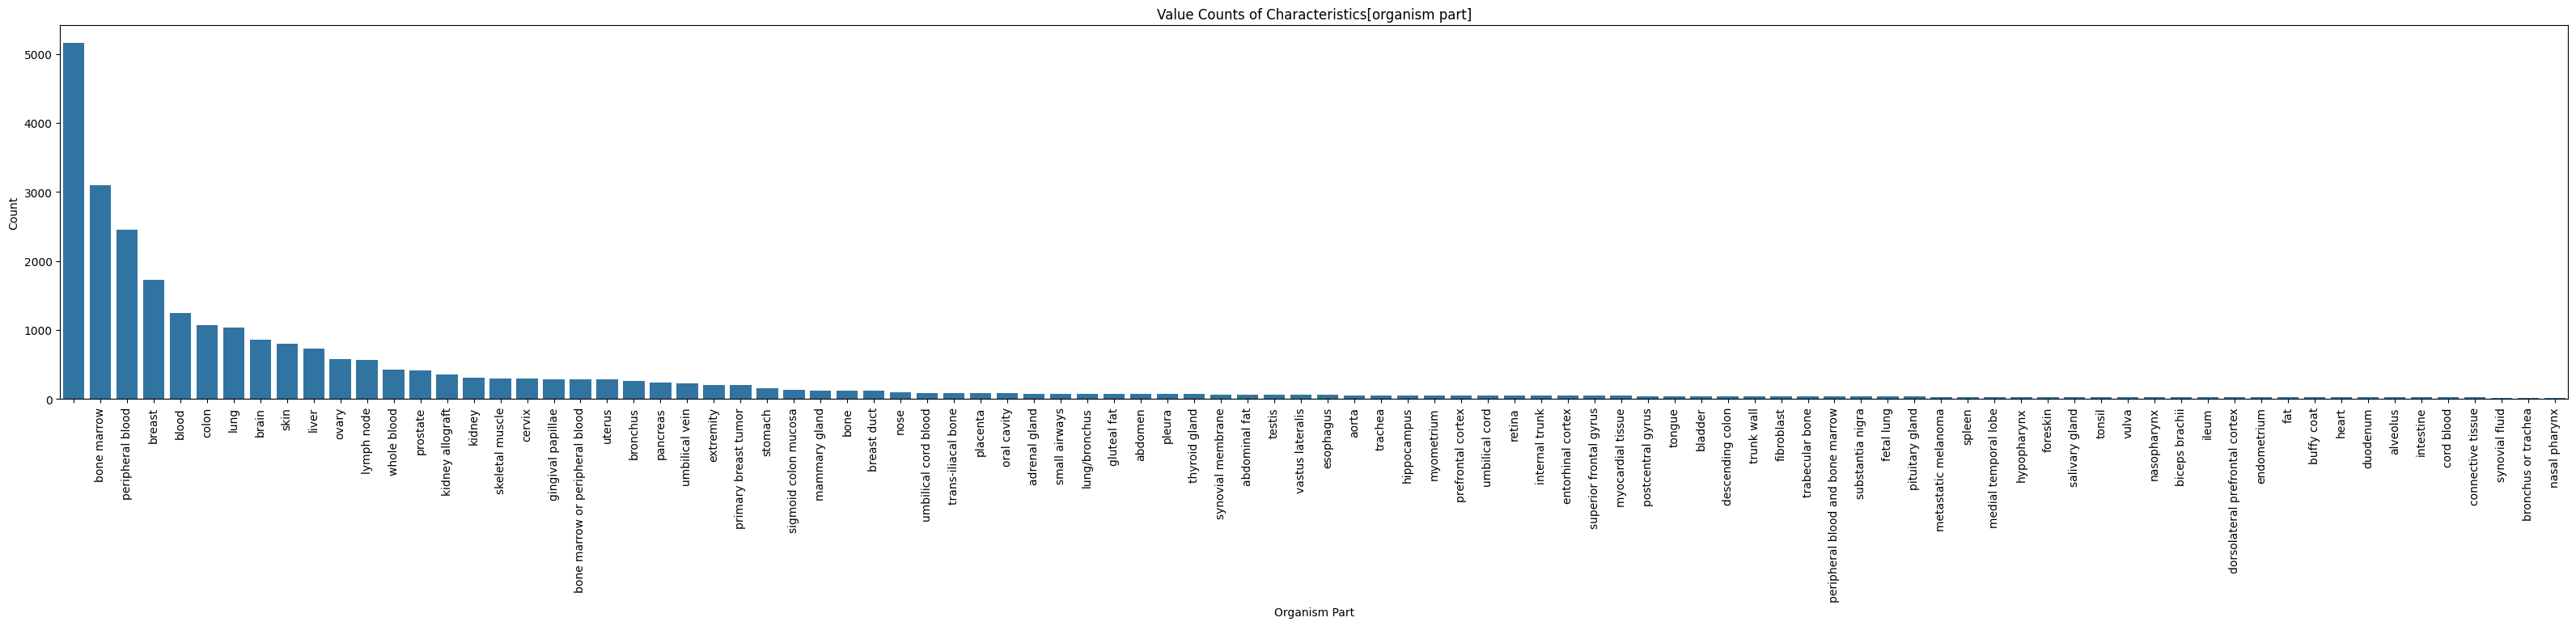

In [14]:
plt.figure(figsize=(40, 6))
sns.barplot(x='Organism Part', y='Count', data=value_counts[value_counts['Count'] >= 20])


plt.xlabel('Organism Part')
plt.ylabel('Count')
plt.title('Value Counts of Characteristics[organism part]')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

In [18]:
len(value_counts[value_counts['Count'] == 1])

24

In [24]:
value_counts.set_index('Organism Part', inplace=True)

In [26]:
organisms_dict = value_counts['Count'].to_dict()

In [29]:
removed_organism = []
for organism in organisms_dict:
    if organisms_dict[organism]  == 1:
        removed_organism.append(organism)

In [30]:
len(removed_organism)

24

In [31]:
removed_ids = [row['Source Name']
               for _, row in meta_sdrf_df.iterrows() if row['Characteristics[organism part]'] in removed_organism]
new_organism = [row['Characteristics[organism part]']
                for _, row in meta_sdrf_df.iterrows() if row['Characteristics[organism part]'] not in removed_organism]

In [34]:
removed_ids

['Sample 241',
 'Sample 987',
 'Sample 1286',
 'Sample 1664',
 'Sample 2959',
 'Sample 6237',
 'Sample 8029',
 'Sample 8036',
 'Sample 8546',
 'Sample 12305',
 'Sample 12760',
 'Sample 14998',
 'Sample 16230',
 'Sample 17241',
 'Sample 19188',
 'Sample 20572',
 'Sample 20576',
 'Sample 21952',
 'Sample 24206',
 'Sample 24700',
 'Sample 26193',
 'Sample 26244',
 'Sample 26274',
 'Sample 27623']

In [53]:
meta_sdrf_df_new = meta_sdrf_df[~meta_sdrf_df['Source Name'].isin(removed_ids)]
print(meta_sdrf_df_new.shape)
meta_sdrf_df_new.head()

(27863, 26)


Source Name Material Type Characteristics[organism]  \
0    Sample 1          cell              Homo sapiens   
1    Sample 2          cell              Homo sapiens   
2    Sample 3          cell              Homo sapiens   
3    Sample 4          cell              Homo sapiens   
4    Sample 5          cell              Homo sapiens   

  Characteristics[cell type] Characteristics[cell line]  \
0      lung cancer cell line                 RERF-LC-KJ   
1   ovarian cancer cell line                    FU-OV-1   
2   colonic cancer cell line                   COLO-205   
3   colonic cancer cell line                       LOVO   
4      lung cancer cell line                       H661   

  Characteristics[tissue supergroup] Characteristics[organism part]  \
0                               lung                           lung   
1                              ovary                          ovary   
2                         colorectal                          colon   
3                         colorectal                          colon   
4                               lung                           lung   

  Characteristics[metastatic tissue] Characteristics[disease]  \
0                     not applicable              lung cancer   
1                     not applicable          ovary carcinoma   
2                            ascites     colon adenocarcinoma   
3                     not applicable             colon cancer   
4                         lymph node   large cell lung cancer   

  Characteristics[clinical history]  ... Labeled Extract Name   Label  \
0                                    ...      Sample 1:biotin  biotin   
1                                    ...      Sample 2:biotin  biotin   
2                                    ...      Sample 3:biotin  biotin   
3                                    ...      Sample 4:biotin  biotin   
4                                    ...      Sample 5:biotin  biotin   

      Assay Name Technology Type Comment [ArrayExpress accession]  \
0  GSM274674.cel     array assay                     E-GEOD-10843   
1  GSM274702.cel     array assay                     E-GEOD-10843   
2  GSM274717.cel     array assay                     E-GEOD-10843   
3  GSM274729.cel     array assay                     E-GEOD-10843   
4  GSM274760.cel     array assay                     E-GEOD-10843   

               Derived Array Data File  \
0  processedMatrix.Aurora.july2015.txt   
1  processedMatrix.Aurora.july2015.txt   
2  processedMatrix.Aurora.july2015.txt   
3  processedMatrix.Aurora.july2015.txt   
4  processedMatrix.Aurora.july2015.txt   

             Comment [Derived ArrayExpress FTP file]   Factor Value[disease]  \
0  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...             lung cancer   
1  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...         ovary carcinoma   
2  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...    colon adenocarcinoma   
3  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...            colon cancer   
4  ftp://ftp.ebi.ac.uk/pub/databases/microarray/d...  large cell lung cancer   

    Factor Value[cell type] Factor Value[cell line]  
0     lung cancer cell line              RERF-LC-KJ  
1  ovarian cancer cell line                 FU-OV-1  
2  colonic cancer cell line                COLO-205  
3  colonic cancer cell line                    LOVO  
4     lung cancer cell line                    H661  

[5 rows x 26 columns]

# Expression array

In [15]:
processed_matrix = processed_matrix.astype(float)

In [36]:
processed_matrix = processed_matrix.T
processed_matrix

CompositeSequence Identifier   1053_at    117_at     121_at  1255_g_at  \
Sample 1                      8.633534  5.706326   8.432861   3.612596   
Sample 2                      7.133591  5.600561  11.214049   3.507581   
Sample 3                      8.750263  5.535385   8.758270   3.490875   
Sample 4                      8.036026  5.583420   8.715002   3.509387   
Sample 5                      8.250181  5.636544   8.505976   3.488148   
...                                ...       ...        ...        ...   
Sample 27883                  7.173749  6.641453   8.026471   3.566565   
Sample 27884                  7.867791  7.795849   7.728130   3.559073   
Sample 27885                  8.398367  7.176745   7.742799   3.688425   
Sample 27886                  5.793442  6.068157   7.969923   3.418513   
Sample 27887                  6.315533  7.052895   7.693903   3.455200   

CompositeSequence Identifier   1294_at   1316_at   1320_at  1405_i_at  \
Sample 1                      6.567162  5.325749  5.025696   4.338246   
Sample 2                      6.276711  5.260778  4.322894   4.052465   
Sample 3                      6.480120  5.534601  4.144125   3.899799   
Sample 4                      6.528172  5.302449  4.435178   3.894054   
Sample 5                      6.076411  5.412223  5.708045   3.800964   
...                                ...       ...       ...        ...   
Sample 27883                  7.041817  5.268652  4.379941   5.027751   
Sample 27884                  7.171607  5.199774  4.490579   5.147501   
Sample 27885                  6.404422  5.376444  4.264321   4.217430   
Sample 27886                  8.158367  5.487724  3.983765  10.993175   
Sample 27887                  7.995070  5.554992  4.143538   5.052262   

CompositeSequence Identifier   1431_at   1438_at  ...  AFFX-r2-Ec-bioD-3_at  \
Sample 1                      3.522877  6.283297  ...             11.049265   
Sample 2                      3.570886  6.251428  ...             11.608204   
Sample 3                      3.596456  8.561863  ...             11.153203   
Sample 4                      3.541536  6.317533  ...             11.285882   
Sample 5                      4.935212  6.060361  ...             11.904885   
...                                ...       ...  ...                   ...   
Sample 27883                  3.559446  5.772818  ...             10.455898   
Sample 27884                  3.561362  6.265012  ...             11.459663   
Sample 27885                  3.580230  6.251063  ...             11.063791   
Sample 27886                  3.870142  5.821989  ...             10.451409   
Sample 27887                  3.599117  5.661664  ...             11.017394   

CompositeSequence Identifier  AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  \
Sample 1                                 10.827462            12.648738   
Sample 2                                 11.386719            12.817432   
Sample 3                                 10.721412            12.992995   
Sample 4                                 10.926944            12.862566   
Sample 5                                 11.428415            13.470386   
...                                            ...                  ...   
Sample 27883                             10.066272            12.920094   
Sample 27884                             11.176060            13.275257   
Sample 27885                             10.648205            13.150965   
Sample 27886                             10.015301            12.336832   
Sample 27887                             10.724629            12.755060   

CompositeSequence Identifier  AFFX-r2-P1-cre-5_at  AFFX-ThrX-3_at  \
Sample 1                                12.388722        5.456769   
Sample 2                                12.675763        5.185190   
Sample 3                                13.016665       11.616415   
Sample 4                                12.817815       12.860514   
Sample 5                               

In [37]:
processed_matrix = processed_matrix[~processed_matrix.index.isin(removed_ids)]
processed_matrix

CompositeSequence Identifier   1053_at    117_at     121_at  1255_g_at  \
Sample 1                      8.633534  5.706326   8.432861   3.612596   
Sample 2                      7.133591  5.600561  11.214049   3.507581   
Sample 3                      8.750263  5.535385   8.758270   3.490875   
Sample 4                      8.036026  5.583420   8.715002   3.509387   
Sample 5                      8.250181  5.636544   8.505976   3.488148   
...                                ...       ...        ...        ...   
Sample 27883                  7.173749  6.641453   8.026471   3.566565   
Sample 27884                  7.867791  7.795849   7.728130   3.559073   
Sample 27885                  8.398367  7.176745   7.742799   3.688425   
Sample 27886                  5.793442  6.068157   7.969923   3.418513   
Sample 27887                  6.315533  7.052895   7.693903   3.455200   

CompositeSequence Identifier   1294_at   1316_at   1320_at  1405_i_at  \
Sample 1                      6.567162  5.325749  5.025696   4.338246   
Sample 2                      6.276711  5.260778  4.322894   4.052465   
Sample 3                      6.480120  5.534601  4.144125   3.899799   
Sample 4                      6.528172  5.302449  4.435178   3.894054   
Sample 5                      6.076411  5.412223  5.708045   3.800964   
...                                ...       ...       ...        ...   
Sample 27883                  7.041817  5.268652  4.379941   5.027751   
Sample 27884                  7.171607  5.199774  4.490579   5.147501   
Sample 27885                  6.404422  5.376444  4.264321   4.217430   
Sample 27886                  8.158367  5.487724  3.983765  10.993175   
Sample 27887                  7.995070  5.554992  4.143538   5.052262   

CompositeSequence Identifier   1431_at   1438_at  ...  AFFX-r2-Ec-bioD-3_at  \
Sample 1                      3.522877  6.283297  ...             11.049265   
Sample 2                      3.570886  6.251428  ...             11.608204   
Sample 3                      3.596456  8.561863  ...             11.153203   
Sample 4                      3.541536  6.317533  ...             11.285882   
Sample 5                      4.935212  6.060361  ...             11.904885   
...                                ...       ...  ...                   ...   
Sample 27883                  3.559446  5.772818  ...             10.455898   
Sample 27884                  3.561362  6.265012  ...             11.459663   
Sample 27885                  3.580230  6.251063  ...             11.063791   
Sample 27886                  3.870142  5.821989  ...             10.451409   
Sample 27887                  3.599117  5.661664  ...             11.017394   

CompositeSequence Identifier  AFFX-r2-Ec-bioD-5_at  AFFX-r2-P1-cre-3_at  \
Sample 1                                 10.827462            12.648738   
Sample 2                                 11.386719            12.817432   
Sample 3                                 10.721412            12.992995   
Sample 4                                 10.926944            12.862566   
Sample 5                                 11.428415            13.470386   
...                                            ...                  ...   
Sample 27883                             10.066272            12.920094   
Sample 27884                             11.176060            13.275257   
Sample 27885                             10.648205            13.150965   
Sample 27886                             10.015301            12.336832   
Sample 27887                             10.724629            12.755060   

CompositeSequence Identifier  AFFX-r2-P1-cre-5_at  AFFX-ThrX-3_at  \
Sample 1                                12.388722        5.456769   
Sample 2                                12.675763        5.185190   
Sample 3                                13.016665       11.616415   
Sample 4                                12.817815       12.860514   
Sample 5                               

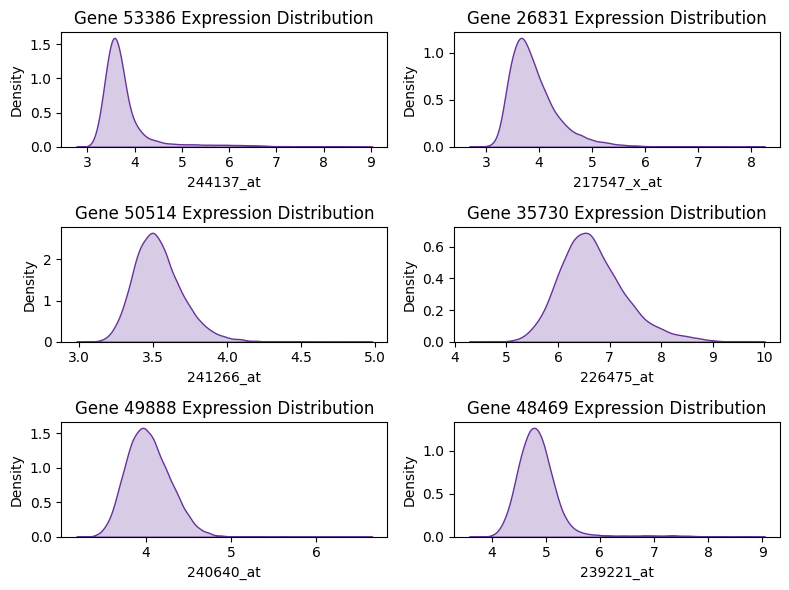

In [44]:
n_genes = [random.randint(1, 54674) for _ in range(6)]

fig, ax = plt.subplots(3, int(len(n_genes)/3), figsize=(8, 6))
ax = ax.flatten()

for i, gene in enumerate(n_genes):
    sns.kdeplot(processed_matrix.iloc[:, gene], fill=True, color="rebeccapurple", ax=ax[i])
    ax[i].set_title(f"Transcript {gene} Expression Distribution")

plt.tight_layout()
plt.show()

# Adata acquisition

In [54]:
processed_matrix.index

Index(['Sample 1', 'Sample 2', 'Sample 3', 'Sample 4', 'Sample 5', 'Sample 6',
       'Sample 7', 'Sample 8', 'Sample 9', 'Sample 10',
       ...
       'Sample 27878', 'Sample 27879', 'Sample 27880', 'Sample 27881',
       'Sample 27882', 'Sample 27883', 'Sample 27884', 'Sample 27885',
       'Sample 27886', 'Sample 27887'],
      dtype='object', length=27863)

In [57]:
processed_matrix.columns

Index(['1053_at', '117_at', '121_at', '1255_g_at', '1294_at', '1316_at',
       '1320_at', '1405_i_at', '1431_at', '1438_at',
       ...
       'AFFX-r2-Ec-bioD-3_at', 'AFFX-r2-Ec-bioD-5_at', 'AFFX-r2-P1-cre-3_at',
       'AFFX-r2-P1-cre-5_at', 'AFFX-ThrX-3_at', 'AFFX-ThrX-5_at',
       'AFFX-ThrX-M_at', 'AFFX-TrpnX-3_at', 'AFFX-TrpnX-5_at',
       'AFFX-TrpnX-M_at'],
      dtype='object', name='CompositeSequence Identifier', length=54674)

In [56]:
meta_sdrf_df_new.set_index('Source Name', inplace=True)
meta_sdrf_df_new

Material Type Characteristics[organism]  \
Source Name                                            
Sample 1              cell              Homo sapiens   
Sample 2              cell              Homo sapiens   
Sample 3              cell              Homo sapiens   
Sample 4              cell              Homo sapiens   
Sample 5              cell              Homo sapiens   
...                    ...                       ...   
Sample 27883          cell              Homo sapiens   
Sample 27884          cell              Homo sapiens   
Sample 27885          cell              Homo sapiens   
Sample 27886          cell              Homo sapiens   
Sample 27887          cell              Homo sapiens   

             Characteristics[cell type] Characteristics[cell line]  \
Source Name                                                          
Sample 1          lung cancer cell line                 RERF-LC-KJ   
Sample 2       ovarian cancer cell line                    FU-OV-1   
Sample 3       colonic cancer cell line                   COLO-205   
Sample 4       colonic cancer cell line                       LOVO   
Sample 5          lung cancer cell line                       H661   
...                                 ...                        ...   
Sample 27883                                                         
Sample 27884                                                         
Sample 27885                                                         
Sample 27886                  CD3 cells                              
Sample 27887                 CD14 cells                              

             Characteristics[tissue supergroup]  \
Source Name                                       
Sample 1                                   lung   
Sample 2                                  ovary   
Sample 3                             colorectal   
Sample 4                             colorectal   
Sample 5                                   lung   
...                                         ...   
Sample 27883                                      
Sample 27884                                      
Sample 27885                                      
Sample 27886                                      
Sample 27887                                      

             Characteristics[organism part]  \
Source Name                                   
Sample 1                               lung   
Sample 2                              ovary   
Sample 3                              colon   
Sample 4                              colon   
Sample 5                               lung   
...                                     ...   
Sample 27883                          brain   
Sample 27884                          brain   
Sample 27885                          brain   
Sample 27886                    bone marrow   
Sample 27887                    bone marrow   

             Characteristics[metastatic tissue] Characteristics[disease]  \
Source Name                                                                
Sample 1                         not applicable              lung cancer   
Sample 2                         not applicable          ovary carcinoma   
Sample 3                                ascites     colon adenocarcinoma   
Sample 4                         not applicable             colon cancer   
Sample 5                             lymph node   large cell lung cancer   
...                                         ...                      ...   
Sample 27883                                                glioblastoma   
Sample 27884                                                glioblastoma   
Sample 27885                                                glioblastoma   
Sample 27886                                            multiple myeloma   
Sample 27887                                            multiple myeloma   

             Characteristics[clinical history] Characteristics[compound]  ...  \
Source Name                

In [58]:
adata = ad.AnnData(X=processed_matrix.values, obs=meta_sdrf_df_new)
adata.var['gene_names'] = processed_matrix.columns

In [59]:
adata

AnnData object with n_obs × n_vars = 27863 × 54674
    obs: 'Material Type', 'Characteristics[organism]', 'Characteristics[cell type]', 'Characteristics[cell line]', 'Characteristics[tissue supergroup]', 'Characteristics[organism part]', 'Characteristics[metastatic tissue]', 'Characteristics[disease]', 'Characteristics[clinical history]', 'Characteristics[compound]', 'Characteristics[growth condition]', 'Characteristics[stimulus]', 'Characteristics[genotype]', 'Characteristics[RNAi]', 'Characteristics[phenotype]', 'Labeled Extract Name', 'Label', 'Assay Name', 'Technology Type', 'Comment [ArrayExpress accession]', 'Derived Array Data File', 'Comment [Derived ArrayExpress FTP file]', 'Factor Value[disease]', 'Factor Value[cell type]', 'Factor Value[cell line]'
    var: 'gene_names'

In [60]:
#adata.write(file_path + '/' + 'adata_E-MTAB-3732.h5ad')

# Adata Analysis

In [5]:
adata = sc.read_h5ad(file_path + '/' + 'adata_E-MTAB-3732.h5ad')
adata

AnnData object with n_obs × n_vars = 27863 × 54674
    obs: 'Material Type', 'Characteristics[organism]', 'Characteristics[cell type]', 'Characteristics[cell line]', 'Characteristics[tissue supergroup]', 'Characteristics[organism part]', 'Characteristics[metastatic tissue]', 'Characteristics[disease]', 'Characteristics[clinical history]', 'Characteristics[compound]', 'Characteristics[growth condition]', 'Characteristics[stimulus]', 'Characteristics[genotype]', 'Characteristics[RNAi]', 'Characteristics[phenotype]', 'Labeled Extract Name', 'Label', 'Assay Name', 'Technology Type', 'Comment [ArrayExpress accession]', 'Derived Array Data File', 'Comment [Derived ArrayExpress FTP file]', 'Factor Value[disease]', 'Factor Value[cell type]', 'Factor Value[cell line]'
    var: 'gene_names'

In [6]:
df_stats = sc.pp.calculate_qc_metrics(adata)

In [ ]:
stats_cells = df_stats[0]
stats_cells

In [7]:
stats_genes = df_stats[1]
stats_genes

n_cells_by_counts  mean_counts  log1p_mean_counts  \
0                  27863     6.924106           2.069910   
1                  27863     6.315269           1.989964   
2                  27863     8.113230           2.209727   
3                  27863     3.653636           1.537649   
4                  27863     7.471643           2.136725   
...                  ...          ...                ...   
54669              27863     5.281857           1.837666   
54670              27863     5.340826           1.847009   
54671              27863     3.132372           1.418852   
54672              27863     3.577253           1.521099   
54673              27863     3.502343           1.504598   

       pct_dropout_by_counts   total_counts  log1p_total_counts  
0                        0.0  192926.367850           12.170069  
1                        0.0  175962.347095           12.078031  
2                        0.0  226058.929033           12.328555  
3                        0.0  101801.261639           11.530788  
4                        0.0  208182.396819           12.246175  
...                      ...            ...                 ...  
54669                    0.0  147168.369084           11.899339  
54670                    0.0  148811.425447           11.910442  
54671                    0.0   87277.291484           11.376857  
54672                    0.0   99673.007044           11.509660  
54673                    0.0   97585.784835           11.488497  

[54674 rows x 6 columns]

In [8]:
sc.pp.highly_variable_genes(adata)
adata

AnnData object with n_obs × n_vars = 27863 × 54674
    obs: 'Material Type', 'Characteristics[organism]', 'Characteristics[cell type]', 'Characteristics[cell line]', 'Characteristics[tissue supergroup]', 'Characteristics[organism part]', 'Characteristics[metastatic tissue]', 'Characteristics[disease]', 'Characteristics[clinical history]', 'Characteristics[compound]', 'Characteristics[growth condition]', 'Characteristics[stimulus]', 'Characteristics[genotype]', 'Characteristics[RNAi]', 'Characteristics[phenotype]', 'Labeled Extract Name', 'Label', 'Assay Name', 'Technology Type', 'Comment [ArrayExpress accession]', 'Derived Array Data File', 'Comment [Derived ArrayExpress FTP file]', 'Factor Value[disease]', 'Factor Value[cell type]', 'Factor Value[cell line]'
    var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [11]:
adata[:, adata.var['highly_variable'] == True]

View of AnnData object with n_obs × n_vars = 27863 × 27
    obs: 'Material Type', 'Characteristics[organism]', 'Characteristics[cell type]', 'Characteristics[cell line]', 'Characteristics[tissue supergroup]', 'Characteristics[organism part]', 'Characteristics[metastatic tissue]', 'Characteristics[disease]', 'Characteristics[clinical history]', 'Characteristics[compound]', 'Characteristics[growth condition]', 'Characteristics[stimulus]', 'Characteristics[genotype]', 'Characteristics[RNAi]', 'Characteristics[phenotype]', 'Labeled Extract Name', 'Label', 'Assay Name', 'Technology Type', 'Comment [ArrayExpress accession]', 'Derived Array Data File', 'Comment [Derived ArrayExpress FTP file]', 'Factor Value[disease]', 'Factor Value[cell type]', 'Factor Value[cell line]'
    var: 'gene_names', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'

In [14]:
genes_sums = np.array(adata.X.sum(axis=0)).flatten()
genes_names = adata.var['gene_names'].values
genes_df = pd.DataFrame({'gene': genes_names, 'total_expr': genes_sums})
genes_df = genes_df.sort_values(by="total_expr", ascending=False)
genes_df = genes_df.reset_index(drop=False)
genes_df.head(10)

index             gene     total_expr
0  54627  AFFX-hum_alu_at  391950.700547
1  10939      201492_s_at  390409.282544
2  14338      204892_x_at  389079.341729
3  16004      206559_x_at  387460.364327
4  10876      201429_s_at  386577.717455
5    974       1553588_at  385155.024882
6    958     1553567_s_at  384948.508322
7  33637        224372_at  384844.224748
8  22173      212869_x_at  382807.905784
9    961     1553570_x_at  382520.831691

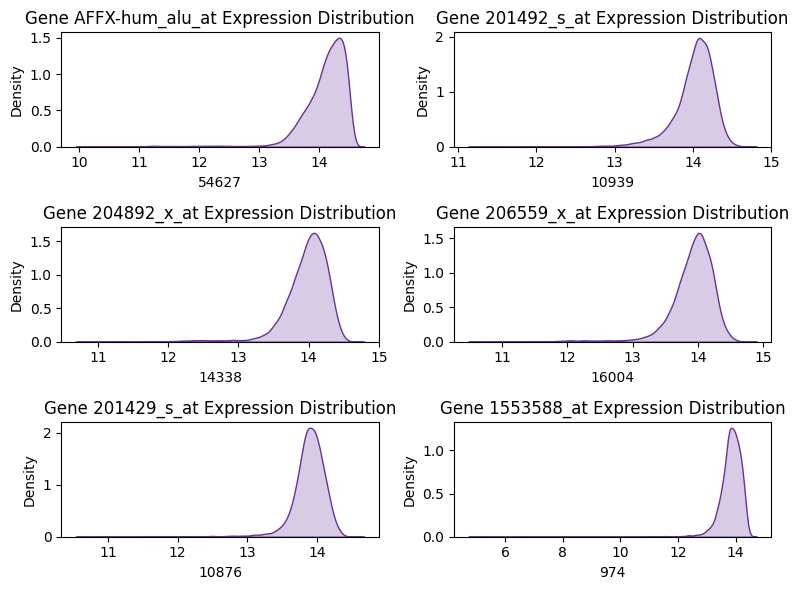

In [15]:
df = df = pd.DataFrame(adata.X)

n_genes = 6

fig, ax = plt.subplots(3, int(n_genes/3), figsize=(8, 6))
ax = ax.flatten()

for i in range(n_genes):
    idx = genes_df.iloc[i]['index']
    gene = genes_df.iloc[i]['gene']
    sns.kdeplot(df.iloc[:, idx], fill=True, color="rebeccapurple", ax=ax[i])
    ax[i].set_title(f"Gene {gene} Expression Distribution")

plt.tight_layout()
plt.show()

In [16]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.scale(adata, zero_center=True) 

In [18]:
genes_sums = np.array(adata.X.sum(axis=0)).flatten()
genes_names = adata.var['gene_names'].values
genes_df = pd.DataFrame({'gene': genes_names, 'total_expr': genes_sums})
genes_df = genes_df.sort_values(by="total_expr", ascending=False)
genes_df = genes_df.reset_index(drop=False)
genes_df.head(10)

index         gene    total_expr
0  10032  200092_s_at  2.134547e-08
1   7690   1564631_at  1.902580e-08
2  10222  200775_s_at  1.212475e-08
3  18109  208695_s_at  1.199020e-08
4     90   1552379_at  1.096604e-08
5  30064    220781_at  1.093639e-08
6   5247   1560251_at  1.082211e-08
7  14338  204892_x_at  1.074639e-08
8  22913  213614_x_at  1.058209e-08
9  17223  207783_x_at  1.024425e-08

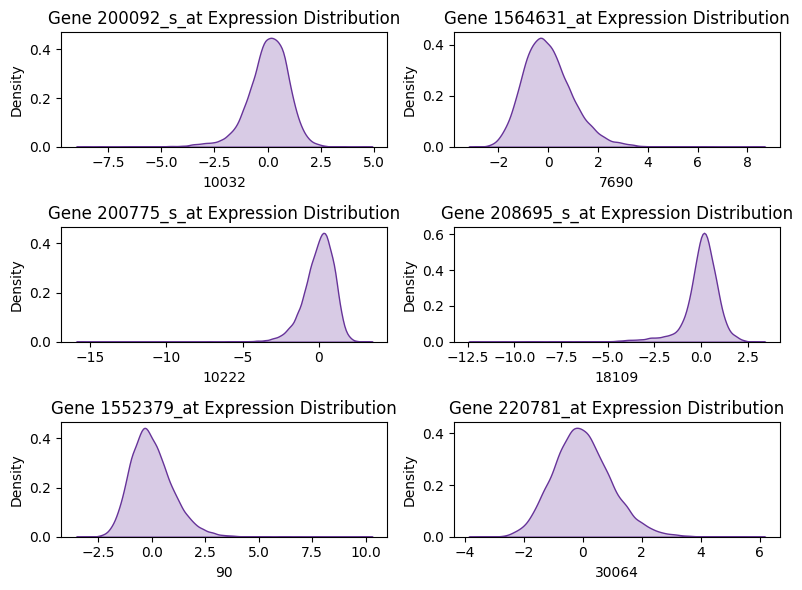

In [19]:
df = df = pd.DataFrame(adata.X)

n_genes = 6

fig, ax = plt.subplots(3, int(n_genes/3), figsize=(8, 6))
ax = ax.flatten()

for i in range(n_genes):
    idx = genes_df.iloc[i]['index']
    gene = genes_df.iloc[i]['gene']
    sns.kdeplot(df.iloc[:, idx], fill=True, color="rebeccapurple", ax=ax[i])
    ax[i].set_title(f"Gene {gene} Expression Distribution")

plt.tight_layout()
plt.show()

In [20]:
df_stats = sc.pp.calculate_qc_metrics(adata)

/opt/conda/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
df_stats[0]

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
Source Name                                                              
Sample 1                  54674                10.909162    605.981502   
Sample 2                  54674                10.909162   2444.571957   
Sample 3                  54674                10.909162   1611.755947   
Sample 4                  54674                10.909162   2559.685584   
Sample 5                  54674                10.909162    118.814182   
...                         ...                      ...           ...   
Sample 27883              54674                10.909162  -8406.767854   
Sample 27884              54674                10.909162  -8339.969082   
Sample 27885              54674                10.909162  -8342.800791   
Sample 27886              54674                10.909162   6548.412498   
Sample 27887              54674                10.909162   6592.800308   

              log1p_total_counts  pct_counts_in_top_50_genes  \
Source Name                                                    
Sample 1                6.408498                   51.545569   
Sample 2                7.802034                   14.690604   
Sample 3                7.385700                   24.863851   
Sample 4                7.848030                   10.716270   
Sample 5                4.785942                  389.574600   
...                          ...                         ...   
Sample 27883                 NaN                   -3.892752   
Sample 27884                 NaN                   -4.691253   
Sample 27885                 NaN                   -4.273390   
Sample 27886            8.787131                    4.500361   
Sample 27887            8.793885                    4.168198   

              pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
Source Name                                                              
Sample 1                        88.926393                   151.919834   
Sample 2                        24.391201                    40.915538   
Sample 3                        40.490604                    65.844902   
Sample 4                        18.348850                    30.971957   
Sample 5                       633.501187                  1007.315902   
...                                   ...                          ...   
Sample 27883                    -6.762932                   -11.649369   
Sample 27884                    -8.005709                   -13.595023   
Sample 27885                    -7.300547                   -12.387889   
Sample 27886                     7.779233                    13.352951   
Sample 27887                     7.225036                    12.570245   

              pct_counts_in_top_500_genes  
Source Name                                
Sample 1                       301.544485  
Sample 2                        79.821246  
Sample 3                       125.484155  
Sample 4                        61.996546  
Sample 5                      1870.297105  
...                                   ...  
Sample 27883                   -22.953736  
Sample 27884                   -26.625440  
Sample 27885                   -24.475610  
Sample 27886                    27.864232  
Sample 27887                    26.210101  

[27863 rows x 8 columns]